In [71]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, assemble
import numpy as np
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

num_players = 3
player_id = 1

In [72]:
messages = []
coin = QuantumCircuit(num_players)

coin.h(0)

for qubit in range(1,num_players):
    coin.cx(0,qubit)

coin.draw()


┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

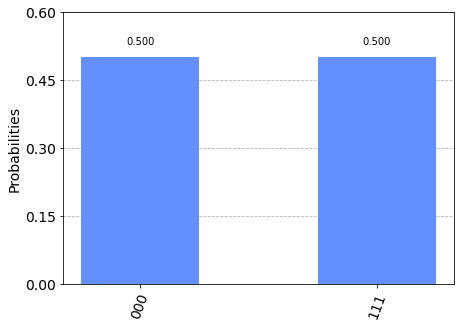

In [73]:
simulator = Aer.get_backend('aer_simulator')
coin.save_statevector()
state = simulator.run(assemble(coin)).result().get_statevector()

#array_to_latex(state, prefix="\\text{Statevector} = ")
plot_histogram(simulator.run(assemble(coin)).result().get_counts())


In [74]:
k = 3*np.log2(num_players)
num_qubits = math.ceil(k)
upper_bound = pow(num_players,3)

registers = []

for a in range(num_players):
    name = 'q' + str(a)
    reg = QuantumRegister(num_qubits, name)
    registers.append(reg)

leader = QuantumCircuit(*registers)

for qubit in range(num_qubits):
    leader.h(registers[0][qubit])
for a in range(1,num_players):
    for qubit in range(num_qubits):
        leader.cx(registers[0][qubit], registers[a][qubit])
        
            

leader.draw()


┌───┐                                                  
q0_0: ┤ H ├──■────────────────────────■──────────────────────
      ├───┤  │                        │                      
q0_1: ┤ H ├──┼────■───────────────────┼────■─────────────────
      ├───┤  │    │                   │    │                 
q0_2: ┤ H ├──┼────┼────■──────────────┼────┼────■────────────
      ├───┤  │    │    │              │    │    │            
q0_3: ┤ H ├──┼────┼────┼────■─────────┼────┼────┼────■───────
      ├───┤  │    │    │    │         │    │    │    │       
q0_4: ┤ H ├──┼────┼────┼────┼────■────┼────┼────┼────┼────■──
      └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │  
q1_0: ─────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──
           └───┘┌─┴─┐  │    │    │    │    │    │    │    │  
q1_1: ──────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──
                └───┘┌─┴─┐  │    │    │    │    │    │    │  
q1_2: ───────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼──
                     └───┘┌─┴─┐  │    │    │    │    │    │  
q1_3: ────────────────────┤ X ├──┼────┼────┼────┼────┼────┼──
                          └───┘┌─┴─┐  │    │    │    │    │  
q1_4: ─────────────────────────┤ X ├──┼────┼────┼────┼────┼──
                               └───┘┌─┴─┐  │    │    │    │  
q2_0: ──────────────────────────────┤ X ├──┼────┼────┼────┼──
                                    └───┘┌─┴─┐  │    │    │  
q2_1: ───────────────────────────────────┤ X ├──┼────┼────┼──
                                         └───┘┌─┴─┐  │    │  
q2_2: ────────────────────────────────────────┤ X ├──┼────┼──
                                              └───┘┌─┴─┐  │  
q2_3: ─────────────────────────────────────────────┤ X ├──┼──
                                                   └───┘┌─┴─┐
q2_4: ──────────────────────────────────────────────────┤ X ├
                                                        └───┘

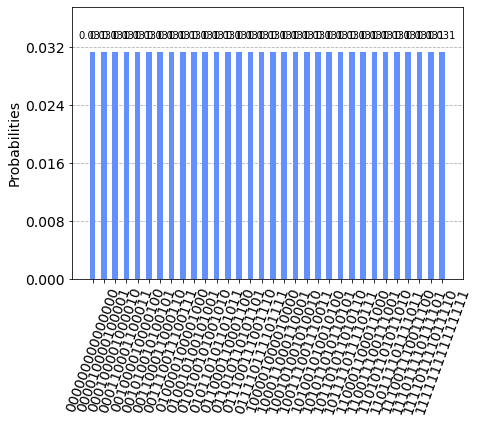

In [75]:
leader.save_statevector()
l_state = simulator.run(assemble(leader)).result().get_statevector()
plot_histogram(simulator.run(assemble(leader)).result().get_counts())
#array_to_latex(l_state, prefix="\\text{Statevector} = ")